Tạo 2 class khác nhau để quản lý các phần về Model và Data riêng rẽ sẽ làm cấu trúc class trở nên rõ ràng, mạch lạc hơn. Class chính vẫn là `LSTM_network` có nhiệm vụ kế thừa các phương thức và thuộc tính của 2 class con là `Model` và `Data`. Nhiệm vụ của các class sẽ như sau:
* Model: Chuyên quản lý các phần liên quan đến mô hình như xây dựng cấu trúc mạng, qui định hàm loss function và thuật toán gradient descent.
* Data: Biến đổi, xử lý và lưu trữ dữ liệu.
* LSTM_network: Điều khiển Model và Data nhằm mục đích đánh giá mô hình và dự báo.

Code của các class sẽ được thiết kế chi tiết như sau:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

series = pd.read_csv('D:\\Do_an_2\\Project_2\\barycenters_output\\cluster_1_barycenter.csv', sep = ',', header = 0, index_col = 0, names = ['date', 'view'])
series.head()

,view
date,
2022-06-22,0.252
2022-06-23,0.195
2022-06-24,0.217
2022-06-25,0.181
2022-06-26,0.146


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as ml
import matplotlib.colors as mc
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


class Model(object):
    """create model for training and fitting"""
    def __init__(self, trainX, trainY, look_back, n_neurons = 100, epochs = 100, batch_size = 16, verbose = 0):
        self.model = Sequential()
        self.look_back = look_back
        self.model.add(GRU(n_neurons, input_shape = (1, look_back)))

        self.model.add(Dropout(0.2))

        self.model.add(Dense(1))


        # self.model.add(GRU(n_neurons, return_sequences=True, input_shape=(1, look_back)))
        # self.model.add(Dropout(0.2))
        # self.model.add(GRU(n_neurons, return_sequences=True))
        # self.model.add(Dropout(0.2))
        # self.model.add(GRU(n_neurons, return_sequences=False))
        # self.model.add(Dropout(0.2))
        # self.model.add(Dense(1))


        self.model.compile(loss = 'mean_squared_error', optimizer = 'adam')
        self.model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = verbose)

    
class Data(object):
    """prepare train/test data"""
    def __init__(self, series, scaler, look_back, split_rate = 2/3):
        self.series = series
        self.split_rate = split_rate
        self.look_back = look_back
        self.data_shift = self.create_shift_series()
        self.scaler, self.trainX, self.trainY, self.testX, self.testY = self.train_test_split(scaler)
        
    def create_shift_series(self):
        self.data_shift = self.series
        cols = ['X']
        for i in range(self.look_back):
            self.data_shift = pd.merge(self.data_shift, self.series.shift(i+1), how='left', left_index=True, right_index=True, suffixes=('', f'_{i+1}'))
            #self.data_shift = pd.merge(self.data_shift, self.series.shift(i+1), how = 'left', left_index = True, right_index = True)
            cols.append('X%s'%(i+1))
        self.data_shift.columns = cols
        self.data_shift.fillna(0, inplace = True)
        self.data_shift = self.data_shift.iloc[self.look_back:, :]
        return self.data_shift
    
    def train_test_split(self, scaler):
        dataset = scaler.fit_transform(self.data_shift)
        train_size = int(len(self.data_shift)*self.split_rate)
        train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
        self.trainX, self.trainY = train[:, 1:], train[:, 0]
        self.testX, self.testY = test[:, 1:], test[:, 0]
        self.trainX = self.trainX.reshape(self.trainX.shape[0], 1, self.trainX.shape[1])
        self.testX = self.testX.reshape(self.testX.shape[0], 1, self.testX.shape[1])
        return scaler, self.trainX, self.trainY, self.testX, self.testY
    
    
class LSTM_network(object):
    """initialize LSTM_network include two attribute
       model: define the neuron network, loss function and algorithm gradient descent
       data: prepare series, train and test dataset and scaler function.
    """
    def __init__(self, model, data):
        self.model = model
        self.data = data
    
    def predict_train_test(self):
        trainPredict = self.model.model.predict(self.data.trainX)
        testPredict = self.model.model.predict(self.data.testX)
        return trainPredict, testPredict
    
    def measure_error(self, trainPredict, testPredict):
        # Invert prediction
        trainPredictInv = self.data.scaler.inverse_transform(np.concatenate((trainPredict, self.data.trainX.reshape(self.data.trainX.shape[0], self.data.trainX.shape[2])), axis = 1))[:, 0]
        testPredictInv = self.data.scaler.inverse_transform(np.concatenate((testPredict, self.data.testX.reshape(self.data.testX.shape[0], self.data.testX.shape[2])), axis = 1))[:, 0]
        # Actual values
        trainYInv = np.array(self.data.data_shift.iloc[:self.data.trainX.shape[0], 0])
        testYInv = np.array(self.data.data_shift.iloc[self.data.trainX.shape[0]:, 0])
        # Calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainYInv[:-1], trainPredictInv[1:]))
        print('Train Score: %.4f RMSE \n' %trainScore)
        testScore = math.sqrt(mean_squared_error(testYInv[:-1], testPredictInv[1:]))
        print('Test Score: %.4f RMSE \n' %testScore)
        

        mae = mean_absolute_error(testYInv[:-1], testPredictInv[1:])
        mse = mean_squared_error(testYInv[:-1], testPredictInv[1:])
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((testYInv[:-1], testPredictInv[1:]) / testYInv[:-1])) * 100
        r2 = r2_score(testYInv[:-1], testPredictInv[1:])

        print('Test Score: %.4f mae \n' %mae)
        print('Test Score: %.4f mse \n' %mse)
        print('Test Score: %.4f rmse \n' %rmse)
        print('Test Score: %.4f mape \n' %mape)
        print('Test Score: %.4f r2 \n' %r2)



        
        fig, ax2 = plt.subplots(figsize=(12, 6))  
        ax2.set_title("cluster_1_barycenter")
        ax2.plot(testYInv, label='Actual Test', color='b')
        ax2.plot(testPredictInv[1:], 'k--', label='Predict Test') 
        legend = ax2.legend(loc='upper right',fontsize='large') 
        plt.show()
        return trainPredictInv, trainYInv, testPredictInv, testYInv
    
    def predict_next(self, n_pred, testPredictInv):
        print("=============================================================================================\n")
        for i in range(n_pred):
            forecastY = self.data.testY.reshape(-1, 1)
            Ypred = self.model.model.predict(forecastY[-self.model.look_back:].reshape(1,1,self.model.look_back))
            forecastY = np.concatenate((forecastY, Ypred), axis = 0)
        forecastY = forecastY[-(n_pred+self.model.look_back+1):]
        inversePredData = [forecastY[-(n_pred+i):] if i == 0 else forecastY[-(n_pred+i):-i] for i in range(self.model.look_back+1)]
        inversePredData = np.concatenate(inversePredData, axis = 1)
        Ypred = self.data.scaler.inverse_transform(inversePredData)[:, 0]
        print("Forecast value in next %d months: %s"%(Ypred.shape[0], Ypred))
        Ymerge = np.concatenate((testPredictInv, Ypred))
        Ygraph = np.concatenate((np.arange(Ymerge.shape[0]).reshape(Ymerge.shape[0], -1), Ymerge.reshape(Ymerge.shape[0], -1)), axis = 1)
        fig, ax = plt.subplots(figsize = (12, 6))
        line_segments = ml.LineCollection([Ygraph[:158], Ygraph[157:]], colors = ['b', 'r'], linestyle = ['solid', 'dashdot'], linewidth = 2)
        ax.add_collection(line_segments)
        ax.autoscale()
        # ax.set_ylabel('view')
        # ax.set_xlabel('date')
        # plt.title('Predict in next %d months'%Ypred.shape[0], fontsize = 'large')
        plt.title('cluster_1_barycenter', fontsize = 'large')
        return Ypred

In [3]:
# Step 1: Chuẩn bị dữ liệu
scaler = MinMaxScaler(feature_range = (0, 1))
data = Data(series = series, scaler = scaler, look_back = 3, split_rate = 2/3)
# Step 2: Khởi tạo mạng LSMT
model = Model(data.trainX, data.trainY, data.look_back, n_neurons = 100, epochs = 100, batch_size = 16, verbose = 0)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Score: 0.1232 RMSE 

Test Score: 0.1807 RMSE 

Test Score: 0.1400 mae 

Test Score: 0.0327 mse 

Test Score: 0.1807 rmse 

Test Score: nan mape 

Test Score: 0.5815 r2 



C:\Users\PC\AppData\Local\Temp\ipykernel_10644\1481008181.py:102: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((testYInv[:-1], testPredictInv[1:]) / testYInv[:-1])) * 100
C:\Users\PC\AppData\Local\Temp\ipykernel_10644\1481008181.py:102: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((testYInv[:-1], testPredictInv[1:]) / testYInv[:-1])) * 100


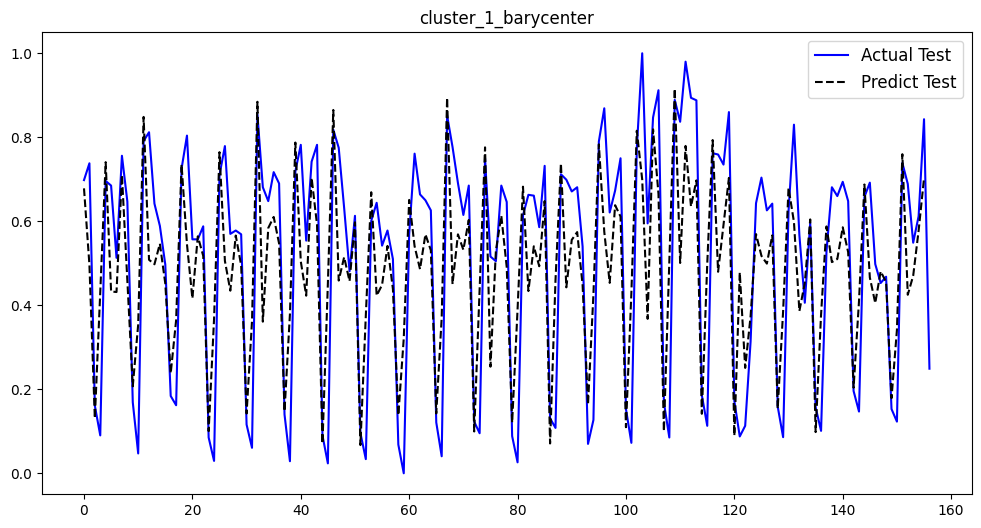


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━

array([0.159     , 0.086     , 0.624     , 0.83      , 0.567     ,
       0.406     , 0.596     , 0.157     , 0.101     , 0.528     ,
       0.681     , 0.66      , 0.694     , 0.648     , 0.196     ,
       0.147     , 0.658     , 0.692     , 0.498     , 0.453     ,
       0.468     , 0.153     , 0.123     , 0.739     , 0.689     ,
       0.549     , 0.612     , 0.843     , 0.249     , 0.33555067])

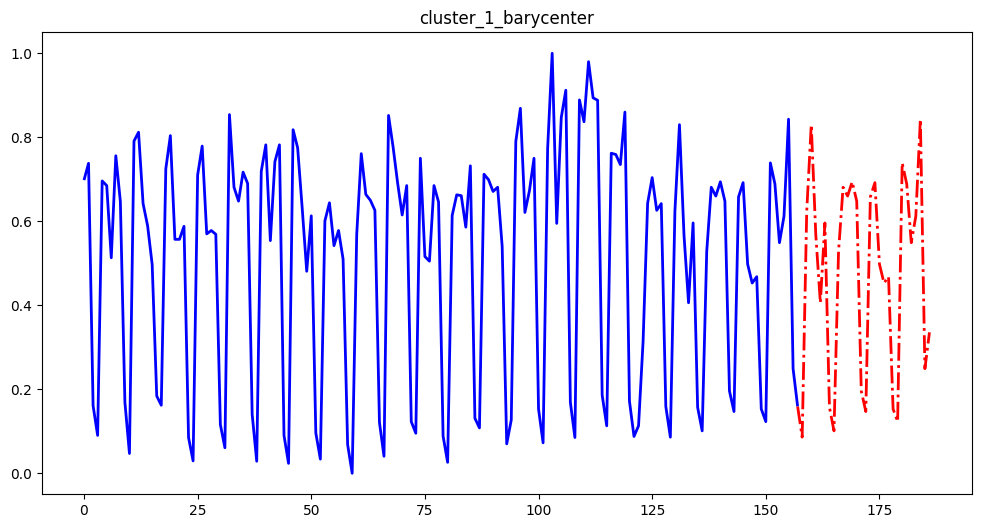

In [4]:
# Step 3: Đánh giá model
# 3.1 Khởi tạo class LSTM network
lstm_nw = LSTM_network(model = model, data = data)
# 3.2 Dự báo trên train và test
trainPredict, testPredict = lstm_nw.predict_train_test()
# 3.3 Đánh giá sai số trên tập train và test
trainPredictInv, trainYInv, testPredictInv, testYInv = lstm_nw.measure_error(trainPredict, testPredict)
# 3.4 Dự báo trong 12 phiên sắp tới
lstm_nw.predict_next(30, testYInv)